## 관련 라이브러리 import

In [62]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## 데이터 로드

In [63]:
# 예시 데이터 로드 (실제 경로를 사용자의 데이터 파일 경로로 바꿔야 함)
df = pd.read_excel('./data/문자클래스데이터.xlsx')

df = df[["Message Body", "label"]]

df

,Message Body,label
0,"[Web발신]\n[KB국민카드]장우진님 08/14 카드대금 561,229원(08/0...",납부 예정
1,"[Web발신]\n[KB국민카드]장우진님 09/13 결제금액 20,000원(연회비 2...",납부 예정
2,"[Web발신]\n[KB국민카드]장우진님 09/14 결제금액 599,554원(연회비 ...",납부 예정
3,"[Web발신]\n[KB국민카드]장우진님 10/16 카드대금 642,364원(09/2...",납부 예정
4,"[Web발신]\n[KB국민카드]장우진님 11/14 카드대금 696,667원(11/0...",납부 예정
...,...,...
304,"[Web발신] MG체크카드(1874) 우*하님 12,500원승인(계좌잔액224,23...",결제 승인
305,"[Web발신] MG체크카드(1874) 우*하님 3,960원승인(계좌잔액236,739...",결제 승인
306,"[Web발신] MG체크카드(1874) 우*하님 40,000원승인(계좌잔액184,23...",결제 승인
307,"[Web발신] SWING 언락패스 이용권(12,900원)이 1일 후 KB국민카드70...",납부 예정


In [64]:
label_to_index = {
    '납부 예정': 0,
    '결제 거절': 1,
    '결제 승인': 2,
    '자동 이체': 3,
    '미납': 4,
    '결제 취소': 5,
    '계좌 개설': 6
}

df['label_index'] = df['label'].map(label_to_index)

## 모델 로드

In [65]:
LSTM_model = load_model('./model/LSTM_model.h5')
CNN_model = load_model('./model/CNN_model.h5')
random_forest_model = joblib.load('./model/random_forest_model.pkl')
naive_bayes_model = joblib.load('./model/naive_bayes_model.pkl')

## 토크나이저와 벡터라이저 로드

In [66]:
# 토크나이저 로드
with open('./tokenizer/tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

In [67]:
tfidf_vectorizer = joblib.load('./vectorizer/tfidf_vectorizer.joblib')

## 데이터 전처리

In [74]:
#딥러닝
sequences = tokenizer.texts_to_sequences(df['Message Body'])
data_for_dl = pad_sequences(sequences, maxlen=50)

dl_x_train, dl_x_test, dl_y_train, dl_y_test = train_test_split(data_for_dl, df['label_index'], test_size=0.3, random_state=42)

#머신러닝
data_for_ml = tfidf_vectorizer.transform(df['Message Body']).toarray()

ml_x_train, ml_x_test, ml_y_train, ml_y_test = train_test_split(data_for_ml, df['label_index'], test_size=0.3, random_state=42)

딥러닝 테스트 데이터의 라벨 분포:
1    21.505376
0    20.430108
2    18.279570
3    15.053763
4    11.827957
5     8.602151
6     4.301075
Name: label_index, dtype: float64

머신러닝 테스트 데이터의 라벨 분포:
1    21.505376
0    20.430108
2    18.279570
3    15.053763
4    11.827957
5     8.602151
6     4.301075
Name: label_index, dtype: float64


## 모델 예측 진행

In [69]:
#딥러닝
cnn_preds = np.argmax(CNN_model.predict(dl_x_test), axis=-1)
lstm_preds = np.argmax(LSTM_model.predict(dl_x_test), axis=-1)

#머신러닝
nb_preds = naive_bayes_model.predict(ml_x_test)
rf_preds = random_forest_model.predict(ml_x_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


## 정확도 계

In [70]:
cnn_accuracy = accuracy_score(dl_y_test, cnn_preds)
lstm_accuracy = accuracy_score(dl_y_test, lstm_preds)
nb_accuracy = accuracy_score(ml_y_test, nb_preds)
rf_accuracy = accuracy_score(ml_y_test, rf_preds)

## 시각화

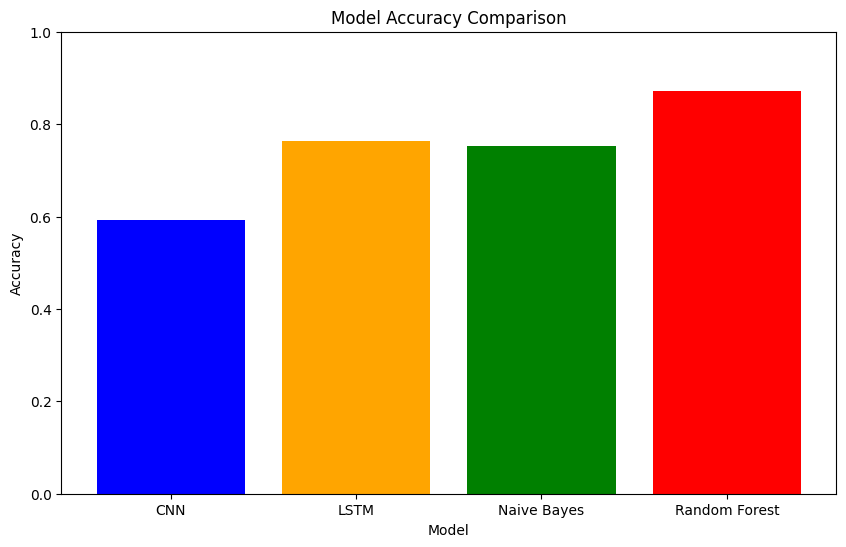

In [71]:
model_names = ['CNN', 'LSTM', 'Naive Bayes', 'Random Forest']
accuracies = [cnn_accuracy, lstm_accuracy, nb_accuracy, rf_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim([0, 1])
plt.show()